In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

#from scipy.misc import imread
from imageio import imread
from collections import namedtuple
import matplotlib.pyplot as plt

from image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from image_utils import preprocess, deprocess, rescale, features_from_img, extract_features
%matplotlib inline

In [2]:
# Load the pre-trained SqueezeNet model.
dtype = torch.FloatTensor
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False


In [3]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    l2 = torch.norm(content_current - content_original)
    loss = content_weight * torch.mul(l2, l2)
    
    return loss


In [ ]:
# experiment with different style losses, to try overcome short-comings of original style transfer algorith
# described in "Neural Style Transfer: A Review", by  Yongcheng Jing, Yezhou Yang, Zunlei Feng, Jingwen Ye,
# Yizhou Yu, and Mingli Song, arXiv:1705.04058v7 30 Oct, 2018.

# compute various statistical metrics to use in style losses:
# - offset gram matrix
# - mean and std
# - autocorrelation
# - laplacian

In [4]:
def offset_gram_matrix(features, offset, normalize=True):
    """
    Compute the Gram matrix from features, where the dot products of the Gram matrix are
    between channels that are offset spatially by 'offset' pixels in each direction
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - offset: offset pixel in each direction Gram matrix
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram_row: gram matrix between image and image shifted in col
                PyTorch Tensor of shape (N, C, C) giving the
                (optionally normalized) Gram matrices for the N input images.
    - gram_col: gram matrix between image and image shifted in col
    """

    N, C, H, W = features.shape
    
    features0 = features[:, :, 0:H-offset, 0:W-offset]    # 0 image offset
    features_rowoff = features[:, :, offset:H, 0:W-offset] #image offset in row
    features_coloff = features[:, :, 0:H-offset, offset:W] #image offset in column
    
    fN0 = torch.reshape(features0, (N,C, (H-offset)*(W-offset)))
    fNrow = torch.reshape(features_rowoff, (N,C, (H-offset)*(W-offset)))
    fNcol = torch.reshape(features_coloff, (N,C, (H-offset)*(W-offset)))
                     
    fN0t = torch.transpose(fN0,1,2)
    fNrowt = torch.transpose(fNrow,1,2)
    fNcolt = torch.transpose(fNcol,1,2)

    gram_row = torch.bmm(fN0, fNrowt) 
    gram_col = torch.bmm(fN0, fNcolt)
    if normalize:
        gram_row = gram_row/((H-offset)*(W-offset)*C)
        gram_col = gram_col/((H-offset)*(W-offset)*C)
        
    return gram_row, gram_col


In [5]:
def gram_style_loss(feats, offset, gram_style_layers, gram_style_targets, gram_style_weights):
    """
    Computes the gram style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - offset: pixel offset in each direction of gram matrix correlation
    - gram_style_layers: List of layer indices into feats giving the layers to include in the
      gram style loss.
    - gram_style_targets: List of the same length as style_layers, where gram_style_targets[i] is
      a tuple of PyTorch Tensors, containing the Gram matrices offset in row and col,
      of the source style image computed at layer style_layers[i].
    - gram_style_weights: List of the same length as style_layers, where gram_style_weights[i]
      is a scalar giving the weight for the style loss at layer gram_style_layers[i].
      
    Returns:
    - gram_style_loss: A PyTorch Tensor holding a scalar giving the gram style loss.
    """

    gram_style_loss = 0
    for i,idx in enumerate(gram_style_layers):
        current_gram_row, current_gram_col = offset_gram_matrix(feats[idx], offset, normalize=True)
        style_gram_row, style_gram_col = gram_style_targets[i]
        l2row = torch.norm(current_gram_row - style_gram_row)
        l2col = torch.norm(current_gram_col - style_gram_col)
        gram_style_loss += gram_style_weights[i]*(torch.mul(l2row,l2row) + torch.mul(l2col,l2col))/2
    return gram_style_loss


In [6]:
def mean_std_vecs(features):
    """
    compute mean of image per channel, and std of image per channel 
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    Returns:
    - mean_vec: PyTorch Tensor of shape (N, C) giving the mean per channel for the N input images
    - std_vec: PyTorch Tensor of shape (N, C) giving the std per channel for the N input images    
    """
    mean_vec = torch.mean(features, [2,3])
    std_vec = torch.std(features, [2,3])
    return mean_vec, std_vec

In [7]:
def stats_style_loss(feats, stats_style_layers, stats_style_targets, stats_style_weights):
    """
     Computes the stats style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - stats_style_layers: List of layer indices into feats giving the layers to include in the
      stats style loss.
    - stats_style_targets: List of the same length as style_layers, where stats_style_targets[i] is
      a tuple containing PyTorch Tensors giving the mean_vec and std_vec of the source style
      image computed at layer stats_style_layers[i].
    - stats_style_weights: List of the same length as stats_style_layers, where stats_style_weights[i]
      is a scalar giving the weight for the style loss at layer stats_style_layers[i].
      
    Returns:
    - stats_style_loss: A PyTorch Tensor holding a scalar giving the stats style loss.
    """
    stats_style_loss = 0
    for i,idx in enumerate(stats_style_layers):
        num_chan = feats[idx].shape[1]
        current_mean, current_std = mean_std_vecs(feats[idx])
        style_mean, style_std = stats_style_targets[i]
        meanl2 = torch.norm(current_mean - style_mean)
        stdl2 = torch.norm(current_std - style_std)
        stats_style_loss += stats_style_weights[i]*  (torch.mul(meanl2,meanl2) + torch.mul(stdl2,stdl2))/num_chan
    return stats_style_loss

In [8]:
def correlation_vecs(features, offset):
    """
    compute the spatial autocorrelation coefficent in each direction of the image, 
    per channel per batch
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - offset: offset pixel in each direction for correlation
    Returns:
    - corr_row: PyTorch Tensor of shape (N, C) giving the autocorrelation coefficient
                at offset in row direction, per channel for the N input images
    - corr_col: PyTorch Tensor of shape (N, C) giving the autocorrelation coefficient 
                at offset in column direction, per channel for the N input images
    """
    N, C, H, W = features.shape
    
    features0 = features[:, :, 0:H-offset, 0:W-offset]    # 0 image offset
    features_rowoff = features[:, :, offset:H, 0:W-offset] #image offset in row
    features_coloff = features[:, :, 0:H-offset, offset:W] #image offset in column
    
    mn0 =  torch.mean(features0, [2,3])
    mn_row = torch.mean(features_rowoff, [2,3])
    mn_col = torch.mean(features_coloff, [2,3])
    
    corr_row = torch.mean(features0*features_rowoff, [2,3]) - torch.mul(mn0,mn_row)
    corr_col = torch.mean(features0*features_coloff, [2,3]) - torch.mul(mn0,mn_col)

    return corr_row, corr_col

In [9]:
def corr_style_loss(feats, offset, corr_style_layers, corr_style_targets, corr_style_weights):
    """
     Computes the correlation style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - offset: pixel offset in each direction of correlation
    - corr_style_layers: List of layer indices into feats giving the layers to include in the
      correlation style loss.
    - corr_style_targets: List of the same length as style_layers, where corr_style_targets[i] is
      a tuple containing PyTorch Tensors giving the autocorrelation in row and col of the source style
      image computed at layer corr_style_layers[i].
    - corr_style_weights: List of the same length as corr_style_layers, where corr_style_weights[i]
      is a scalar giving the weight for the style loss at layer corr_style_layers[i].
      
    Returns:
    - corr_style_loss: A PyTorch Tensor holding a scalar giving the correlation style loss.
    """
    corr_style_loss = 0
    for i,idx in enumerate(corr_style_layers):
        num_chan = feats[idx].shape[1]
        current_corr_row, current_corr_col = correlation_vecs(feats[idx], offset)
        style_corr_row, style_corr_col = corr_style_targets[i]
        corr_rowl2 = torch.norm(current_corr_row - style_corr_row)
        corr_coll2 = torch.norm(current_corr_col - style_corr_col)
        corr_style_loss += corr_style_weights[i]*  (torch.mul(corr_rowl2,corr_rowl2) + torch.mul(corr_coll2,corr_coll2))/num_chan
    return corr_style_loss

In [10]:
def laplacian_vec(features):
    """
    compute the mean absolute laplacian of the image, per channel per batch
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    Returns:
    - laplacian: PyTorch Tensor of shape (N, C) giving the mean absolute laplacian of the image,
            per channel per batch
    """
    N, C, H, W = features.shape
    
    f0 = features[:, :, 1:-1, 1:-1]    
    fm10 = features[:, :, 0:-2, 1:-1]  
    fp10 = features[:, :, 2:, 1:-1]  
    f0m1 = features[:, :, 1:-1, 0:-2]  
    f0p1 = features[:, :, 1:-1, 2:] 
    laplacian = torch.abs(fm10 + fp10 + f0m1 + f0p1 - 4*f0)
    laplacian = torch.mean(laplacian, [2,3])
    return laplacian

In [17]:
def lap_style_loss(feats, lap_style_layers, lap_style_targets, lap_style_weights):
    """
     Computes the laplacian style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - lap_style_layers: List of layer indices into feats giving the layers to include in the
      laplacian style loss.
    - lap_style_targets: List of the same length as style_layers, where lap_style_targets[i] is
      a PyTorch Tensor giving the mean absolute value of the laplacian per channel of the source style
      image computed at layer lap_style_layers[i].
    - lap_style_weights: List of the same length as lap_style_layers, where lap_style_weights[i]
      is a scalar giving the weight for the style loss at layer lap_style_layers[i].
      
    Returns:
    - lap_style_loss: A PyTorch Tensor holding a scalar giving the laplacian style loss.
    """
    lap_style_loss = 0
    for i,idx in enumerate(lap_style_layers):
        num_chan = feats[idx].shape[1]
        current_lap = laplacian_vec(feats[idx])
        style_lap = lap_style_targets[i]
        lap_l2 = torch.norm(current_lap - style_lap)
        lap_style_loss += lap_style_weights[i]*  torch.mul(lap_l2,lap_l2)/num_chan
    return lap_style_loss

In [12]:
content_image = 'images/tubingen.jpg'
image_size = 192
content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
feats = extract_features(content_img, cnn)



In [13]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """

    vert_diff = img[0,:, 1:, :]-img[0,:, :-1, :]
    vert_loss = torch.sum(torch.mul(vert_diff, vert_diff))
    
    horiz_diff = img[0,:, :, 1:]-img[0,:, :,:-1]
    horiz_loss = torch.sum(torch.mul(horiz_diff, horiz_diff))
    loss = tv_weight * (vert_loss + horiz_loss)
    return loss

In [14]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight, 
                   gram_offset, gram_style_layers, gram_style_weights, 
                   stats_style_layers, stats_style_weights,
                   corr_offset, corr_style_layers, corr_style_weights,
                   lap_style_layers, lap_style_weights,
                   tv_weight, hyper_params):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - gram_offset: pixel offset in each direction in gram matrix 
    - gram_style_layers: list of layers to use for gram_style loss
    - gram_style_weights: list of weights to use for each layer in gram_style_layers
    - stats_style_layers: list of layers to use for stats_style loss
    - stats_style_weights: list of weights to use for each layer in stats_style_layers
    - corr_offset: pixel offset in each direction in correlation
    - corr_style_layers: list of layers to use for corr_style loss
    - corr_style_weights: list of weights to use for each layer in corr_style_layers
    - lap_style_layers: list of layers to use for lap_style loss
    - lap_style_weights: list of weights to use for each layer in lap_style_layers
    - tv_weight: weight of total variation regularization term
    - hyper_params: dict of hyper parameters
    """
    # get hyper parameters
    initial_lr = hyper_params['initial_lr']
    decayed_lr = hyper_params['decayed_lr']
    decay_lr_at = hyper_params['decay_lr_at']
    max_iter = hyper_params['max_iter']
    clamp_iter = hyper_params['clamp_iter']
    clamp_val = hyper_params['clamp_val'] 
    init_random = hyper_params['init_random'] 
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image - for all the type of styles implemented
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    gram_style_targets = []
    for idx in gram_style_layers:
        gram_style_targets.append(offset_gram_matrix(feats[idx].clone(), gram_offset))
    stats_style_targets = []
    for idx in stats_style_layers:
        stats_style_targets.append(mean_std_vecs(feats[idx].clone()))
    corr_style_targets = []
    for idx in corr_style_layers:
        corr_style_targets.append(correlation_vecs(feats[idx].clone(), corr_offset))
    lap_style_targets = []
    for idx in lap_style_layers:
        lap_style_targets.append(laplacian_vec(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(max_iter):
        if t < clamp_iter:
            img.data.clamp_(-1*clamp_val, clamp_val)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss as sum of losses for different styles, weighted
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        gs_loss = gram_style_loss(feats, gram_offset, gram_style_layers, gram_style_targets, gram_style_weights)
        ss_loss = stats_style_loss(feats, stats_style_layers, stats_style_targets, stats_style_weights)
        cs_loss = corr_style_loss(feats, corr_offset, corr_style_layers, corr_style_targets, corr_style_weights)
        ls_loss = lap_style_loss(feats, lap_style_layers, lap_style_targets, lap_style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + gs_loss + ss_loss + cs_loss + ls_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

In [25]:
# Set up optimization hyperparameters
hyper_params={}
hyper_params['initial_lr'] = 3.0
hyper_params['decayed_lr'] = 0.1
hyper_params['decay_lr_at'] = 180
hyper_params['max_iter'] = 200
hyper_params['clamp_iter'] = 190
hyper_params['clamp_val'] = 1.5
hyper_params['init_random'] = False

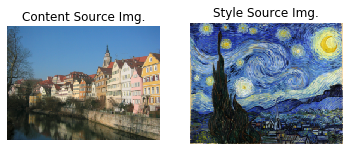

Iteration 0


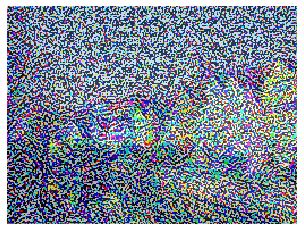

Iteration 100


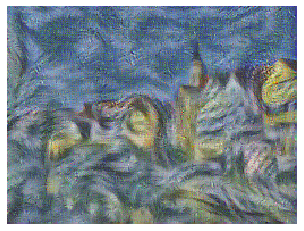

Iteration 199


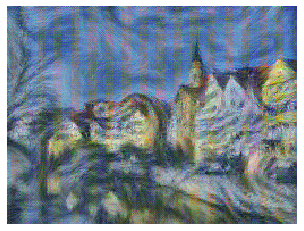

In [50]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'images/tubingen.jpg',
    'style_image' : 'images/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'gram_offset': 0,
    'gram_style_layers' : [1, 4, 6, 7],
    'gram_style_weights' : [300000, 1000, 15, 3],
    'stats_style_layers': [1, 4, 6, 7],
    'stats_style_weights':[300000, 1000, 15, 3],
    'corr_offset': 1,
    'corr_style_layers' : [1, 4, 6, 7],
    'corr_style_weights' : [50000, 200, 10, 1],
    'lap_style_layers': [1, 4, 6, 7],
    'lap_style_weights':[50000, 200, 10, 1],
    'tv_weight' : 2e-2,
    'hyper_params' : hyper_params
}

style_transfer(**params3)

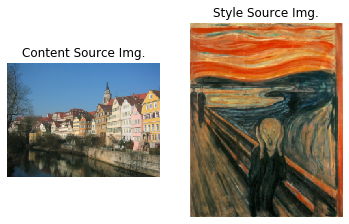

Iteration 0


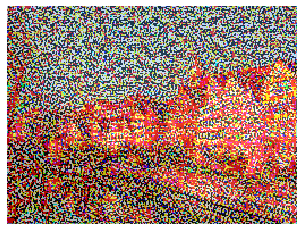

Iteration 100


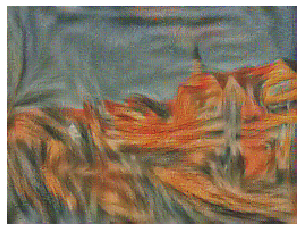

Iteration 199


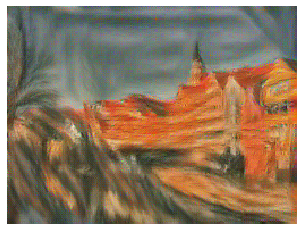

In [57]:
# The Scream + Tubingen
params4 = {
    'content_image' : 'images/tubingen.jpg',
    'style_image' : 'images/the_scream.jpg',
    'image_size' : 192,
    'style_size' : 224,
    'content_layer' : 3,
    'content_weight' : 4e-2,
    'gram_offset': 0,
    'gram_style_layers' : [1, 4, 6, 7],
    'gram_style_weights' : [200000, 800, 12, 1],
    'stats_style_layers': [1, 4, 6, 7],
    'stats_style_weights':[100000, 400, 8, 1],
    'corr_offset': 1,
    'corr_style_layers' : [1, 4, 6, 7],
    'corr_style_weights' : [100, 10, 1, 0.1],
    'lap_style_layers': [1, 4, 6, 7],
    'lap_style_weights':[5000, 50, 2, 1],
    'tv_weight' : 2e-2,
    'hyper_params' : hyper_params
}

style_transfer(**params4)

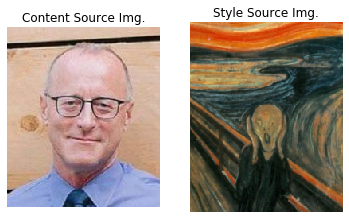

Iteration 0


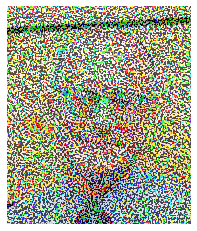

Iteration 100


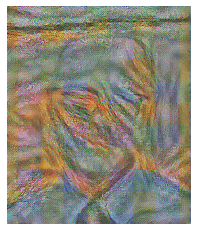

Iteration 199


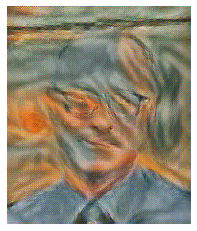

In [70]:

params5 = {
    'content_image' : 'images/gordon.jpg',
    'style_image' : 'images/the_scream_crop.jpg',  
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'gram_offset': 0,
    'gram_style_layers' : [1, 4, 6, 7],
    'gram_style_weights' : [200000, 800, 12, 1],
    'stats_style_layers': [1, 4, 6, 7],
    'stats_style_weights':[100000, 400, 8, 1],
    'corr_offset': 1,
    'corr_style_layers' : [1, 4, 6, 7],
    'corr_style_weights' : [5000, 50, 10, 1],
    'lap_style_layers': [1, 4, 6, 7],
    'lap_style_weights':[10000, 200, 20, 1],
    'tv_weight' : 2e-2,
    'hyper_params' : hyper_params
}

style_transfer(**params5)

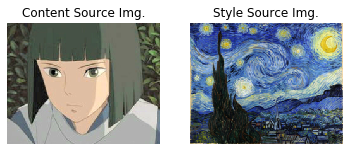

Iteration 0


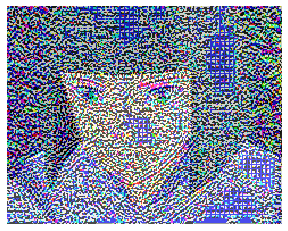

Iteration 100


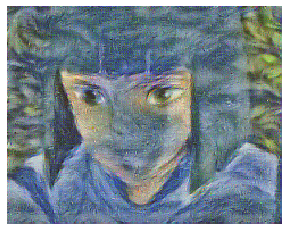

Iteration 199


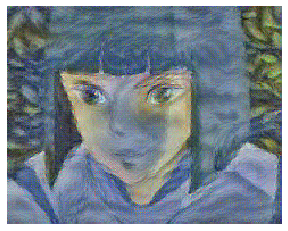

In [72]:

params6 = {
    'content_image' : 'images/haku.jpg',
    'style_image' : 'images/starry_night.jpg',  
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'gram_offset': 0,
    'gram_style_layers' : [1, 4, 6, 7],
    'gram_style_weights' : [300000, 1000, 15, 3],
    'stats_style_layers': [1, 4, 6, 7],
    'stats_style_weights':[300000, 1000, 15, 3],
    'corr_offset': 1,
    'corr_style_layers' : [1, 4, 6, 7],
    'corr_style_weights' : [10000, 100, 10, 1],
    'lap_style_layers': [1, 4, 6, 7],
    'lap_style_weights':[100000, 500, 20, 1],
    'tv_weight' : 2e-2,
    'hyper_params' : hyper_params
}

style_transfer(**params6)

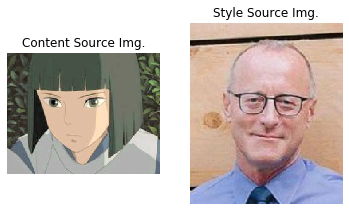

Iteration 0


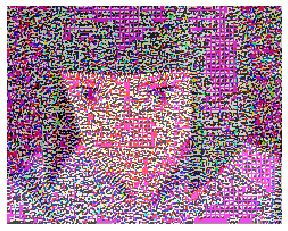

Iteration 100


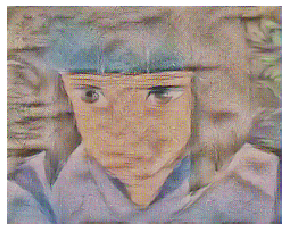

Iteration 199


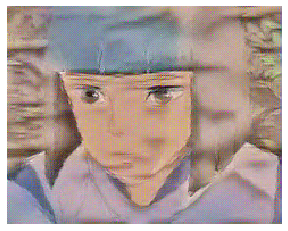

In [77]:
params7 = {
    'content_image' : 'images/haku.jpg',
    'style_image' : 'images/gordon.jpg',  
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'gram_offset': 0,
    'gram_style_layers' : [1, 4, 6, 7],
    'gram_style_weights' : [300000, 1000, 15, 3],
    'stats_style_layers': [1, 4, 6, 7],
    'stats_style_weights':[100000, 500, 10, 1],
    'corr_offset': 1,
    'corr_style_layers' : [1, 4, 6, 7],
    'corr_style_weights' : [1000, 100, 1, 1],
    'lap_style_layers': [1, 4, 6, 7],
    'lap_style_weights':[1000, 100, 10, 1],
    'tv_weight' : 2e-2,
    'hyper_params' : hyper_params
}

style_transfer(**params7)